# Titanic: Machine Learning from Disaster

## 1. Introduction

The business question is how to accurately forecast Titanic passengers survival rate given their information. To this end, a predictive model using machine learning algorithms is presented. For further details on the case study, see [here](https://www.kaggle.com/c/titanic). 

## 2. Data understanding

The dataset provided by Kaggle is devided into two separated sets that are training and test sets, respectively. The target variable, i.e., passenger survival, has been excluded from the test dataset.

### 2.1. Import libraries

In [1]:
import warnings
def ignore_warnings(*args, **kwargs):
    pass
warnings.warn = ignore_warnings 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection  import train_test_split, KFold, StratifiedKFold  
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

### 2.2. Load data

In [2]:
df = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

titanic = df.append(test)
titanic.reset_index(inplace=True)
titanic.drop('index',inplace=True,axis=1)
print("Dimension of Titanic dataset: {}".format(titanic.shape)+"\n")
print("Dimension of train dataset: {}".format(df.shape)+"\n")
print("Dimension of test dataset: {}".format(test.shape)+"\n")

df = df.drop('PassengerId', axis = 1)
df.info()

Dimension of Titanic dataset: (1309, 12)

Dimension of train dataset: (891, 12)

Dimension of test dataset: (418, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB


### 2.3. Data exploration

#### 2.3.1. Descriptive summaries

In [3]:
#The train set columns
print("The dataset columns: {}". format(titanic.columns))

The dataset columns: Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket'],
      dtype='object')


In [4]:
#The train set
print(df.head(10))

   Survived  Pclass                                               Name  \
0         0       3                            Braund, Mr. Owen Harris   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         1       3                             Heikkinen, Miss. Laina   
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         0       3                           Allen, Mr. William Henry   
5         0       3                                   Moran, Mr. James   
6         0       1                            McCarthy, Mr. Timothy J   
7         0       3                     Palsson, Master. Gosta Leonard   
8         1       3  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)   
9         1       2                Nasser, Mrs. Nicholas (Adele Achem)   

      Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked  
0    male  22.0      1      0         A/5 21171   7.2500   NaN        S  
1  female  38.0      1      0        

In [5]:
print("Check missing values in the train set: " + "\n")
df.apply(lambda x: sum(x.isnull()))

Check missing values in the train set: 



Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [6]:
print("Check missing values in the test set: " + "\n")
test.apply(lambda x: sum(x.isnull()))

Check missing values in the test set: 



PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

'Age' and 'Cabin' have a considerable number of missing values in the "Titanic" dataset. There are only two and one values missing in "Embarked" and "Fare", respectively, in the dataset.

In [206]:
#Numerical variables analysis
print("Get summary of numerical variables: "+"\n")
print(titanic.loc[:,['Age', 'SibSp', 'Parch', 'Fare']].describe())

Get summary of numerical variables: 

               Age        SibSp        Parch         Fare
count  1046.000000  1309.000000  1309.000000  1308.000000
mean     29.881138     0.498854     0.385027    33.295479
std      14.413493     1.041658     0.865560    51.758668
min       0.170000     0.000000     0.000000     0.000000
25%      21.000000     0.000000     0.000000     7.895800
50%      28.000000     0.000000     0.000000    14.454200
75%      39.000000     1.000000     0.000000    31.275000
max      80.000000     8.000000     9.000000   512.329200


* An interesting observation is the seventy-five percent of "Fare" values do not excced 31 while the maximum fare value is 512.

In [8]:
#Categorical variables analysis
print("Get summary of categorical variables: " + "\n")

cat_var=[i for i in ['Survived','Pclass', 'Sex', 'Embarked']]

for i in cat_var:
     print (df[i].value_counts()) 

#df.dtypes[df.dtypes == "object"].index.drop(['Name', 'Ticket', 'Cabin'])

Get summary of categorical variables: 

0    549
1    342
Name: Survived, dtype: int64
3    491
1    216
2    184
Name: Pclass, dtype: int64
male      577
female    314
Name: Sex, dtype: int64
S    644
C    168
Q     77
Name: Embarked, dtype: int64


* The survival rate for the train set is %40

* The number of the lowest class passengers dominates the tow other classes as expected

* The number of male passengers is quite twice of  the female ones

* The boarding port of most passnegers is Southampton

#### 2.3.2. Data visualization

In [336]:
#Set up helper function for data visualization 
def plt_cross(dataset, target, cat):
    df_temp = pd.crosstab(df[target], df[cat]).plot(kind = 'bar', stacked='True')
    plt.xlabel(target)
    plt.ylabel('Count of passengers')
    plt.title(target+" vs "+cat)
    
def plt_cat(dataset, cat, target):   
    ax = sns.FacetGrid(dataset,  margin_titles=True, size = 4)
    ax = ax.map(sns.barplot, cat, target) 
    ax.add_legend()
    
def box_plot(dataset, col, by_var = []):
    df.boxplot(column = col, by = by_var)
    
def bi_hist(dataset, feature, target):
    plt.figure(figsize=(12,7))
    plt.hist([df[df[target]==1][feature].dropna(), df[df[target]==0][feature].dropna()], stacked=True, color = ['g','b'],
         bins = 20,label = ['Survived','Not survived'])
    plt.xlabel('feature')
    plt.ylabel('Count of passengers')
    plt.legend()
    
def plot_correlation_map(dataset):
    corr = dataset.corr()
    _ , ax = plt.subplots(figsize =(7, 6))
    _ = sns.heatmap(
        corr, 
        cmap = sns.diverging_palette(200, 10, as_cmap = True),
        square=True, 
        #cbar_kws={'shrink': 0.9}, 
        ax=ax, 
        annot = True, 
        #annot_kws = {'fontsize': 12}
    )    

Let start by plotting survival count per each category of survived and non-survived passengers. 

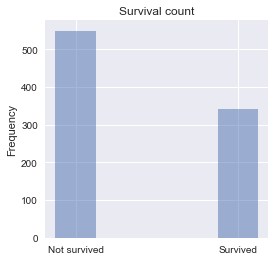

In [10]:
#Plot survival distribution
plt.figure(figsize=(4,4))
labels = ('Not survived', 'Survived')
x_pos = np.arange(len(labels))
plt.bar(x_pos, df['Survived'].value_counts(), align='center', alpha=0.5, width=0.25)
plt.xticks(x_pos, labels)
plt.ylabel('Frequency')
plt.title('Survival count')

The death and survival rates in the training dataset is calculated below. According to that, 61.6% of passengers did not survive in the wrecked ship, which might not be considered as an imbalanced case. 

In [11]:
100*df.groupby('Survived')['Survived'].count()/df.shape[0]

Survived
0    61.616162
1    38.383838
Name: Survived, dtype: float64

Now, we procced with exploring the distribution of ticket class by survival variable. Further, we analyze the portion of survivd passengers per each ticket class. 

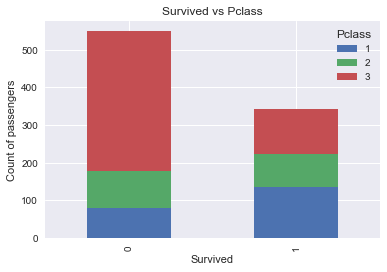

In [12]:
#Plot cross tabular survival per passenger classe
plt_cross(df, 'Survived', 'Pclass')

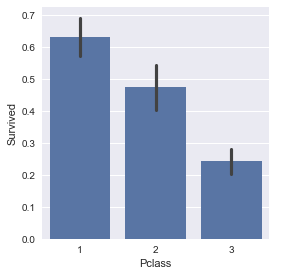

In [13]:
#Plot survival count per passenger classe
plt_cat(df, 'Pclass', 'Survived')

As illustrated above, the passnegers holding higher-class tickets have the highest chance of survival. They are, then, followed by the middle-class tickets. The larget group of sunk passengers belong to the lower-class ticket. 

Now that the same analysis is done for gender and embarkation port as shown below. 

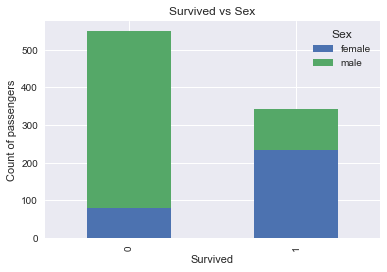

In [14]:
#Plot cross tabular survival per gender
plt_cross(df, 'Survived', 'Sex')

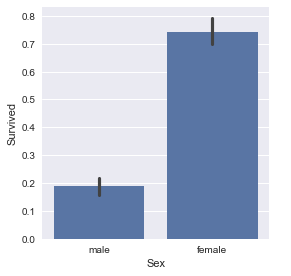

In [15]:
#Plot survival count per gender
plt_cat(df, 'Sex', 'Survived')

As shown, most people survived are females. 

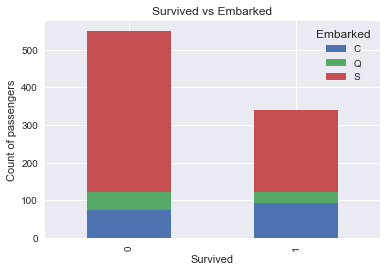

In [16]:
#Plot cross tabular survival per port of embarkation
plt_cross(df, 'Survived', 'Embarked')

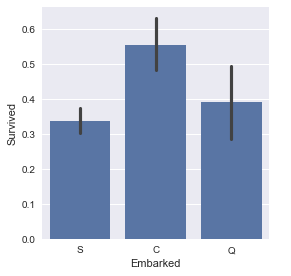

In [17]:
#Plot survival count per port of embarkation
plt_cat(df, 'Embarked', 'Survived')

As mentioned earlier, females are luckier than males. It can be particularly due to the sailing ethics. We can also expect that children have higher survival chance. To examine the validity of such assumption, the distribution of age variable is plotted as follows.

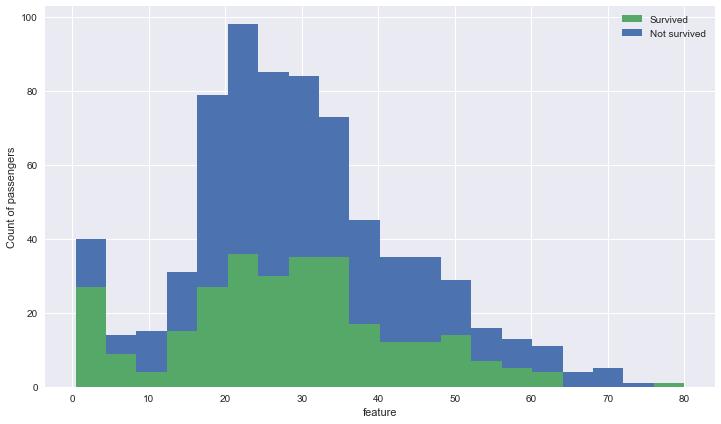

In [18]:
bi_hist(df, 'Age', 'Survived')

Let's plot passengers' age distribution per gender in the full dataset.

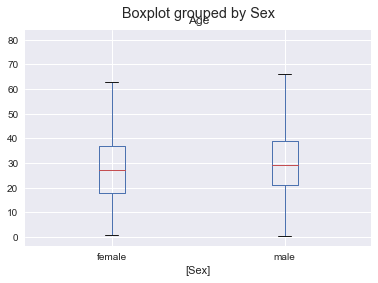

In [207]:
box_plot(titanic, 'Age', ['Sex'])

As the following box plot illustrates, age distribution is quite different within and between ticket classes and gender. It is an important observation as whether a passenger is male/female or which ticket class owns might aggregate a fair estimation of age. For example, the female passengers in the lower class of tickets are considered as the youngest group of Titanic passenfers.  

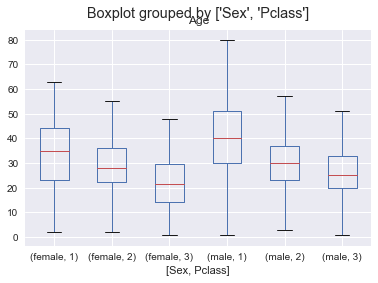

In [208]:
box_plot(titanic, 'Age', ['Sex', 'Pclass'])

Finally, we plot the correlation matrix which investigates the dependence between multiple variables. As shown by the correlation plot, SibSp and Parch are quite correlated.

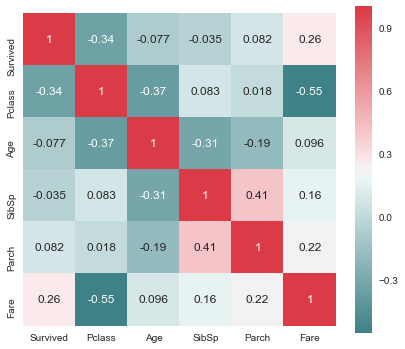

In [337]:
plot_correlation_map(df)

## 3. Data munging

### 3.1. Imputing missing values

Recall that we obserevd missing values in some variables. The number of missing values per each variable in Titanic dataset, except the target one, is given below.  

In [306]:
titanic.drop(['PassengerId', 'Survived'], axis =1).apply(lambda x: sum(x.isnull()))

Age          263
Cabin       1014
Embarked       2
Fare           1
Name           0
Parch          0
Pclass         0
Sex            0
SibSp          0
Ticket         0
dtype: int64

As it can be observed, four features contain missing values required to be treated. 

In [3]:
# Fare
titanic['Fare'].fillna(titanic.Fare.median(), inplace = True)

In [4]:
# Embarked
titanic['Embarked'].fillna(titanic.Embarked.mode()[0], inplace = True)

In [5]:
# Cabin
titanic['Cabin'].fillna("N", inplace = True) #replacing temporarily missing values by N
titanic['Cabin']=titanic['Cabin'].dropna().map(lambda x: x[0])
pd.crosstab(titanic['Pclass'], titanic['Cabin'])

Cabin,A,B,C,D,E,F,G,N,T
Pclass,,,,,,,,,
1,22,65,94,40,34,0,0,67,1
2,0,0,0,6,4,13,0,254,0
3,0,0,0,0,3,8,5,693,0


As the analysis of cabin number per ticket class suggests, the missing value for this feature can be estimated wisely given the mode value for all categories of cabin number per each Pclass. 

In [6]:
for i, row in titanic.iterrows():
    titanic.loc[(titanic['Pclass']==1) & (titanic['Cabin']=="N"), 'Cabin'] = 'C'
    titanic.loc[(titanic['Pclass']==2) & (titanic['Cabin']=="N"), 'Cabin'] = 'F'
    titanic.loc[(titanic['Pclass']==3) & (titanic['Cabin']=="N"), 'Cabin'] = 'F' 

In [7]:
# Age
titanic['Age'] = titanic.groupby(['Sex','Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

### 3.2. Feature engineering

In this section, we attempt to create new features using the exisitng ones to extract more information from the dataset. The first feature to be explored is passengers name. See [here](https://github.com/ahmedbesbes/How-to-score-0.8134-in-Titanic-Kaggle-Challenge/blob/master/titanic-article.ipynb) for further details.  

In [8]:
#Introducing title
def get_titles(data):
    
    Title_Dictionary = {
                        "Capt":       "Officer",
                        "Col":        "Officer",
                        "Major":      "Officer",
                        "Jonkheer":   "Royalty",
                        "Don":        "Royalty",
                        "Sir" :       "Royalty",
                        "Dr":         "Officer",
                        "Rev":        "Officer",
                        "the Countess":"Royalty",
                        "Dona":       "Royalty",
                        "Mme":        "Mrs",
                        "Mlle":       "Miss",
                        "Ms":         "Mrs",
                        "Mr" :        "Mr",
                        "Mrs" :       "Mrs",
                        "Miss" :      "Miss",
                        "Master" :    "Master",
                        "Lady" :      "Royalty"

                        }
    
    data['Title'] = data['Name'].map(lambda x:x.split(',')[1].split('.')[0].strip())
        
    data['Title'] = data['Title'].map(Title_Dictionary)
    
    return data

titanic=get_titles(titanic)

Then, a new variable is defined representing families size as follows.

In [9]:
#Introducing family size
def family_size(data):
    
    data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
    
    data['Singleton'] = data['FamilySize'].map(lambda x : 1 if x == 1 else 0)
    data['SmallFamily'] = data['FamilySize'].map(lambda x : 1 if 2<=x<=4 else 0)
    data['LargeFamily'] = data['FamilySize'].map(lambda x : 1 if 5<=x else 0)
    
    return data

titanic=family_size(titanic)

Finally, all categorical variables are converted into numerical ones and the unnecessary variables are dropped from the dataset. 

In [10]:
titanic= titanic.drop(['Name', 'Parch', 'SibSp', 'Ticket'], axis=1)

In [11]:
var_mod=titanic.dtypes[titanic.dtypes == "object"].index.tolist()
var_mod.append('Pclass')
le = LabelEncoder()
for i in var_mod:
    titanic[i] = le.fit_transform(titanic[i])

## 4. Predictive model

We define a class to implement predictive models which contains training, testing, and cross-vaidation. 

In [23]:
class _pred_model(object):

    def __init__(self, dataSet, predictor, outcome, clf, grid_params):
        self.data = dataSet
        self.X = predictor
        self.y = outcome
        self.clf = clf(**grid_params)
        self.grid_params = grid_params
    
    # Hyperparameter tuning and building a model
    def learning_(self):
        # Splitting data into random train and test subsets
        X_train, X_test, y_train, y_test = train_test_split(self.data[self.X], self.data[self.y], test_size = 0.30
                                                            , random_state = 0)
                        
        # Wrapping scoring function
        acc_scorer = make_scorer(accuracy_score)
        
        # Grid search
        _grid = GridSearchCV(self.clf, self.grid_params, scoring=acc_scorer, cv=StratifiedKFold(n_splits=5))
        self.clf = _grid.fit(X_train, y_train).best_estimator_
        
        print(self.clf)
        
        print('Best score: {}'.format(_grid.best_score_))

        # Fitting a predictive model to the training set
        self.clf.fit(X_train, y_train) 
        
        # Predicting the test set
        y_pred = self.clf.predict(X_test)

        # Calculating the accuracy of the model using the test set
        accuracy = accuracy_score(y_test,y_pred)#*100
        print("Accuracy: {:5.5f}".format(accuracy))
        
        self._kfold()
           
        return self.clf
    
    def _kfold(self):
        
        #Performing k-fold cross-validation
        kf = KFold(n_splits = 5)
        error = []

        # Filter training data
        for train, test in kf.split(self.data):
            train_X = (self.data[self.X].iloc[train, :])
            train_y = self.data[self.y].iloc[train]

        # Training and testing the algorithm using the predictors and target
        self.clf.fit(train_X, train_y)
        pred = self.clf.predict(self.data[self.X].iloc[test,:])

        #Record error from each cross-validation 
        error.append(accuracy_score(self.data[self.y].iloc[test], pred))
        print("Cross-Validation score: {:5.5f}".format(np.mean(error)))        

### 4.1. Random forests

The first predictive model to be built is random forests which is a special variant of bagging.

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Best score: 0.8346709470304976
Accuracy: 0.82463
Cross-Validation score: 0.86517


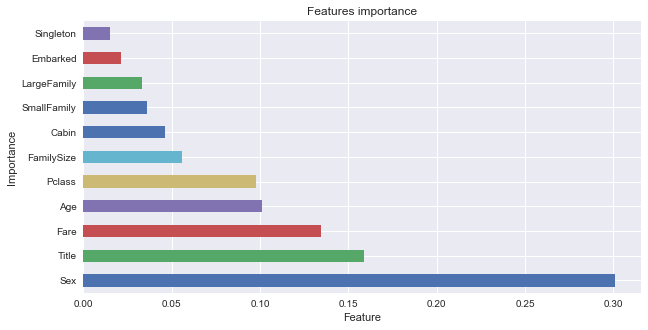

Dimension of final set: (418, 2)

     PassengerId  Survived
891          892         0
892          893         0
893          894         0
894          895         0
895          896         1


In [24]:
# Random forests objects
dataset = titanic[:891].drop('PassengerId', axis=1)
predictor = titanic.drop(['PassengerId', 'Survived'], axis = 1).columns.tolist()
outcome = 'Survived'
rf_params  = {'n_estimators': [2, 4, 10, 15, 20, 50, 100, 200], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10]
             }

rf = _pred_model(dataset, predictor, outcome, clf = RandomForestClassifier, grid_params = rf_params)
clf = rf.learning_()

#Feature importance:
featimp = pd.Series(clf.feature_importances_, index=predictor).sort_values(ascending=False)

plt.figure(figsize = (10, 5))
pd.Series(clf.feature_importances_, index=predictor).sort_values(ascending=False).plot(kind = 'barh')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Features importance')
plt.show()

# Predict actual data set
_Survived = clf.predict(titanic[891:].drop(['Survived', 'PassengerId'], axis=1)).astype(int)
_PassengerId = titanic[891:].PassengerId
_rf = pd.DataFrame({'PassengerId': _PassengerId ,'Survived': _Survived})
print("Dimension of final set: {}".format(_rf.shape)+"\n")
print(_rf.head())
_rf.to_csv('_rf.csv', index = False)

### 4.1. XGBoost

XGBoost is an advanced implementation gradient boosted machines designed for speed and performance. In order to grow a powerful XGboost predictive model, special attention should be dedicated to the parameter tuning. In what follows, we take a generic approach to tune the parameters. Needless to say, one might explore a more efficient way to build a more powerful model. In the first step, we choose a relatively high learning rate and determine the optimal number of trees for this learning rate using the bulit-in cross-validation function in XGBoost.  

    test-error-mean  test-error-std  train-error-mean  train-error-std
0          0.207071        0.020719          0.126805         0.005112
1          0.195819        0.021895          0.125199         0.004458
2          0.195832        0.014098          0.127205         0.004782
3          0.191006        0.011697          0.123595         0.003701
4          0.195806        0.010513          0.123193         0.003465
5          0.192619        0.013470          0.123191         0.006479
6          0.195806        0.016252          0.119981         0.004726
7          0.192606        0.018150          0.118377         0.005923
8          0.190994        0.012521          0.117173         0.005866
9          0.190981        0.013341          0.114365         0.005519
10         0.189381        0.022184          0.112358         0.004169
11         0.189368        0.021497          0.110351         0.005181
12         0.190955        0.024066          0.108744         0.005800
13    

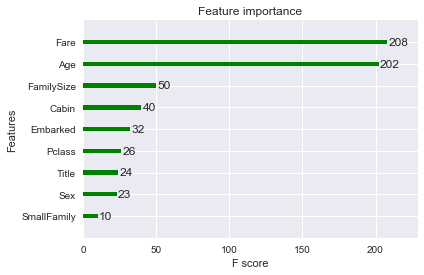

In [16]:
#Define a function to create XGBoost models and perform cross-validation
predictor = titanic.drop(['PassengerId', 'Survived'], axis = 1).columns.tolist()
dataset = titanic[:891].drop('PassengerId', axis=1)
outcome = 'Survived'

X_train, X_test, y_train, y_test = train_test_split(dataset[predictor], dataset[outcome], 
                                                    test_size = 0.30, random_state = 0)
    
def _modelfit(xgb_model, dataset, outcome, **kwargs):  
    
    #Load data into DMatrix
    dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
   
    #Do corss-validation to tune the number of boosting rounds
    cvresult = xgb.cv(xgb_model.get_xgb_params(), dtrain, num_boost_round=xgb_model.get_params()['n_estimators'], 
                          nfold=5, metrics='error', 
                          early_stopping_rounds=50, 
                          seed = 0)  

    n_boosting=cvresult.index[cvresult['test-error-mean'] == cvresult['test-error-mean'].min()].tolist()[0]+1
    print(cvresult)
    print("The number of boosting rounds is {0:} and the minimum error is {1:1.6f}"
          .format(n_boosting,cvresult['test-error-mean'].min()))
    xgb_model.set_params(n_estimators=n_boosting)
    print("The number of trees picked by CV: {}".format(n_boosting))
            #cvresult.shape[0])

        
    #Fit the algorithm on the data:
    xgb_model.fit(X_train, y_train, eval_metric='error') #auc
        
    dtrain_predictions = xgb_model.predict(X_test)
    dtrain_predprob = xgb_model.predict_proba(X_test)[:,1]
        
    print ("Accuracy score (test): {}".format(accuracy_score(y_test, dtrain_predictions)))
    
    #Visualization
    plot_importance(xgb_model, color = 'green')
    plt.show()
    
clf = XGBClassifier(max_depth=6, n_estimators=2000, objective='binary:logistic', 
                     subsample=1.0, colsample_bytree=1.0, random_state = 0)

_modelfit(clf, dataset, outcome, predictor = predictor)

The accuracy of the best model using the test dataset is 82.83%.

The next step is to tune the tree-specific parameters as follows.

In [60]:
# max_depth and min_child_weight
def _grid_depth_weight(dataset, predictor, outcome):
       
    param_test = {
     'max_depth':[i for i in range(3,11,1)],
     'min_child_weight':[i for i in range(1,11,1)]    
    }
    
    clf = XGBClassifier(n_estimators = 23, objective='binary:logistic', subsample=1.0, colsample_bytree=1.0, random_state=0)
     
    _grid = GridSearchCV(clf, param_grid=param_test, scoring='accuracy', 
                         n_jobs=4, cv=StratifiedKFold(n_splits=5)).fit(X_train,y_train) #roc_auc
    
    clf=_grid.best_estimator_.fit(X_train,y_train)
    
    return _grid.best_params_, _grid.best_score_

_grid_depth_weight(dataset, predictor, outcome)

({'max_depth': 6, 'min_child_weight': 5}, 0.8314606741573034)

In [61]:
#minimum loss reduction
def _grid_gamma(dataset, predictor, outcome):
    
    param_test = {
      'gamma':[i/10.0 for i in range(0,20)]   
    }
    
    clf = XGBClassifier(n_estimators =23, objective='binary:logistic', max_depth=6, min_child_weight=5, 
                        subsample=1.0, colsample_bytree=1.0, random_state=0)
    
    _grid = GridSearchCV(clf, param_grid = param_test, scoring='accuracy',n_jobs=4, 
                         cv=StratifiedKFold(n_splits=5)).fit(X_train,y_train)
    
    clf=_grid.best_estimator_.fit(X_train, y_train)
    
    return _grid.best_params_, _grid.best_score_

_grid_gamma(dataset, predictor, outcome)

({'gamma': 0.0}, 0.8314606741573034)

In [62]:
# subsample and colsample_bytree
def _grid_sample(dataset, predictor, outcome):
    
    param_test = {
    'subsample':[i/10.0 for i in range(1,11)],
    'colsample_bytree':[i/10.0 for i in range(1,11)]  
    }
    
    clf = XGBClassifier(n_estimators=23, objective='binary:logistic', max_depth=6, min_child_weight=5, 
                                                     gamma = 0.0, seed =0)
    
    _grid = GridSearchCV(clf, param_grid = param_test, scoring='accuracy',n_jobs=4, 
                         cv=StratifiedKFold(n_splits=5)).fit(X_train,y_train)
    
    clf=_grid.best_estimator_.fit(X_train,y_train)
    
    return _grid.best_params_, _grid.best_score_

_grid_sample(dataset, predictor, outcome) 

({'colsample_bytree': 0.7, 'subsample': 0.9}, 0.8346709470304976)

Next, tune the regularization parameter

In [63]:
# tuning alpha
def _grid_reg(dataset, predictor, outcome):
    
    param_test = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05, 1, 100]  
    }
    
    clf = XGBClassifier(n_estimators=23, objective='binary:logistic', max_depth=6, min_child_weight=5, 
                                                     gamma = 0.0, subsample = 0.9, colsample_bytree = 0.7, seed = 0)   
                         
    _grid = GridSearchCV(clf, param_grid = param_test, scoring='accuracy',n_jobs=4, 
                         cv=StratifiedKFold(n_splits=5)).fit(X_train,y_train)
    
    clf=_grid.best_estimator_.fit(X_train,y_train)
    
    return _grid.best_params_, _grid.best_score_

_grid_reg(dataset, predictor, outcome)  

({'reg_alpha': 0.05}, 0.8362760834670947)

Finally, build the predictive model with the determined parameters.

    test-error-mean  test-error-std  train-error-mean  train-error-std
0          0.198955        0.024980          0.184586         0.007915
1          0.194181        0.020803          0.178565         0.011390
2          0.192503        0.042359          0.171749         0.005457
3          0.200542        0.033104          0.165725         0.008371
4          0.192529        0.038262          0.164125         0.013152
5          0.182877        0.042771          0.163723         0.013343
6          0.192568        0.035015          0.160507         0.010133
7          0.181316        0.023690          0.157704         0.007878
8          0.189316        0.033452          0.158910         0.010521
9          0.186129        0.030661          0.155699         0.005182
10         0.186129        0.021202          0.154092         0.005418
11         0.186129        0.026076          0.155697         0.002933
12         0.184529        0.020381          0.155295         0.004037
13    

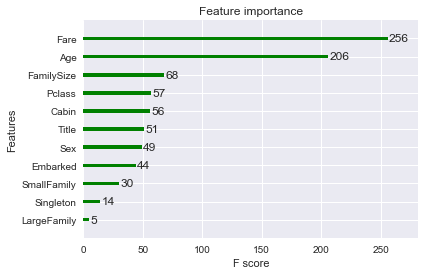

In [75]:
clf = XGBClassifier(
 learning_rate =0.05,
 n_estimators=2000,
 max_depth=6,
 min_child_weight=5,
 gamma=0.0,
 subsample=0.9,
 colsample_bytree=0.7,
 reg_alpha = 0.05,
 objective='binary:logistic',
 random_state=0)

_modelfit(clf, dataset, outcome)

The accuracy of the best model using the test dataset is 84.33%.

In [76]:
# Predict actual data set
_Survived = clf.predict(titanic[891:].drop(['Survived', 'PassengerId'], axis=1)).astype(int)
_PassengerId = titanic[891:].PassengerId
_xgb = pd.DataFrame({'PassengerId': _PassengerId ,'Survived': _Survived})
print("Dimension of final set: {}".format(_xgb.shape)+"\n")
print(_xgb.head())
_xgb.to_csv('_xgb.csv', index = False)

Dimension of final set: (418, 2)

     PassengerId  Survived
891          892         0
892          893         0
893          894         0
894          895         0
895          896         1


For the pedagogical purpose, in what follows, a predictive model using XGBoost native API is also implemented. Of course, its performance can be further improved to build a more accurate model.  

In [34]:
# XGBoost native API 
predictor = titanic[:891].drop(['PassengerId', 'Survived'], axis = 1)
outcome = titanic.loc[:890, 'Survived']

X_train, X_test, y_train, y_test = train_test_split(predictor, outcome, test_size = 0.30, random_state = 0)

def _xgb_model():
      
    #Load data into DMatrix
    dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
    dtest = xgb.DMatrix(X_test.values, label=y_test.values)

    params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'eta':0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'binary:logistic',
    'eval_metric': 'error',
    'random_state': 0
    }
    
    num_boost_round = 2000 
    
    _xgb = xgb.train(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtest, "eval")], #, (dtrain,'train')
        early_stopping_rounds=50
    )
    
    print("Best error rate: {:1.6f} with {} rounds".format(_xgb.best_score, _xgb.best_iteration+1))
    
    _xgb.dump_model('dump.raw.txt')

_xgb_model() 

[0]	eval-error:0.186567
Will train until eval-error hasn't improved in 50 rounds.
[1]	eval-error:0.190299
[2]	eval-error:0.186567
[3]	eval-error:0.182836
[4]	eval-error:0.175373
[5]	eval-error:0.175373
[6]	eval-error:0.16791
[7]	eval-error:0.16791
[8]	eval-error:0.164179
[9]	eval-error:0.156716
[10]	eval-error:0.164179
[11]	eval-error:0.160448
[12]	eval-error:0.16791
[13]	eval-error:0.171642
[14]	eval-error:0.171642
[15]	eval-error:0.171642
[16]	eval-error:0.175373
[17]	eval-error:0.175373
[18]	eval-error:0.179104
[19]	eval-error:0.175373
[20]	eval-error:0.179104
[21]	eval-error:0.179104
[22]	eval-error:0.179104
[23]	eval-error:0.175373
[24]	eval-error:0.171642
[25]	eval-error:0.171642
[26]	eval-error:0.179104
[27]	eval-error:0.179104
[28]	eval-error:0.179104
[29]	eval-error:0.171642
[30]	eval-error:0.171642
[31]	eval-error:0.171642
[32]	eval-error:0.171642
[33]	eval-error:0.171642
[34]	eval-error:0.171642
[35]	eval-error:0.175373
[36]	eval-error:0.171642
[37]	eval-error:0.16791
[38]	e

In [35]:
#Define a function to  perform cross-validation    
def _cv_depth_child():  
    
    #Load data into DMatrix
    dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
    
    params = {
    'eta':0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'binary:logistic',
    'random_state': 0
    }
    
    gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1,12)
    for min_child_weight in range(1,12)
    ]
    
    min_error = float("Inf")
    best_params = None
    for max_depth, min_child_weight in gridsearch_params:
        
        # Updating the parameters
        params['max_depth'] = max_depth
        params['min_child_weight'] = min_child_weight
   
        #Corss-validation to tune the number of boosting rounds
        cv_result = xgb.cv(params, dtrain, num_boost_round=2000, nfold=5, metrics={'error'}, early_stopping_rounds=50, seed = 0)  
    
        # Updating error                                                                            
        mean_error = cv_result['test-error-mean'].min()
        boost_rounds = cv_result['test-error-mean'].argmin()
        if mean_error < min_error:
            min_error = mean_error
            best_params = (max_depth, min_child_weight)
        
    print("max_depth: {}, min_child_weight: {}, Error: {:1.7f}".format(best_params[0], best_params[1], min_error))

_cv_depth_child()

max_depth: 4, min_child_weight: 1, Error: 0.1588128


In [36]:
#Define a function to perform cross-validation    
def _cv_gamma():  
    
    #Load data into DMatrix
    dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
    
    params = {
    'eta':0.3,
    'max_depth': 4,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:logistic',
    'random_state': 0
    }
    
    gridsearch_params = [gamma/10.0 for gamma in range(0,20)]
    
    min_error = float("Inf")
    best_params = None
    for gamma in gridsearch_params:
        
        # Updating the parameter
        params['gamma'] = gamma
   
        #Corss-validation to tune the number of boosting rounds
        cv_result = xgb.cv(params, dtrain, num_boost_round=2000, nfold=5, metrics={'error'}, early_stopping_rounds=50, seed = 0)  
    
        # Updating error                                                                            
        mean_error = cv_result['test-error-mean'].min()
        boost_rounds = cv_result['test-error-mean'].argmin()
        if mean_error < min_error:
            min_error = mean_error
            best_params = gamma
        
    print("gamma: {}, Error: {:1.7f}".format(best_params, min_error))

_cv_gamma()

gamma: 0.0, Error: 0.1588128


In [37]:
#Define a function to perform cross-validation    
def _cv_colsample_subsample():  
    
    #Load data into DMatrix
    dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
    
    params = {
    'eta':0.3,
    'max_depth': 4,
    'min_child_weight': 1,
    'gamma': 0,    
    'objective':'reg:logistic',
    'random_state': 0
    }
    
    gridsearch_params = [
        (subsample, colsample_bytree)
        for subsample in [i/10. for i in range(1,11)]
        for colsample_bytree in [i/10. for i in range(1,11)]
    ]
    
    min_error = float("Inf")
    best_params = None
    for subsample, colsample_bytree in gridsearch_params:
        
        # Updating the parameters
        params['subsample'] = subsample
        params['colsample_bytree'] = colsample_bytree
   
        #Corss-validation to tune the number of boosting rounds
        cv_result = xgb.cv(params, dtrain, num_boost_round=2000, nfold=5, metrics={'error'}, early_stopping_rounds=50, seed = 0)  
    
        # Updating error                                                                            
        mean_error = cv_result['test-error-mean'].min()
        boost_rounds = cv_result['test-error-mean'].argmin()
        if mean_error < min_error:
            min_error = mean_error
            best_params = (subsample, colsample_bytree)
        
    print("subsample: {}, colsample_bytree: {}, Error: {:1.7f}".format(best_params[0], best_params[1], min_error))

_cv_colsample_subsample()

subsample: 1.0, colsample_bytree: 1.0, Error: 0.1588128


In [38]:
#Define a function to perform cross-validation    
def _cv_alpha():  
    
    #Load data into DMatrix
    dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
    
    params = {
    'eta':0.3,
    'max_depth': 4,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:logistic',
    'random_state': 0
    }
    
    gridsearch_params = [0, 0.001, 0.005, 0.01, 0.05, 1, 100]
    
    min_error = float("Inf")
    best_params = None
    for alpha in gridsearch_params:
        
        # Updating the parameter
        params['alpha'] = alpha
   
        #Corss-validation to tune the number of boosting rounds
        cv_result = xgb.cv(params, dtrain, num_boost_round=2000, nfold=5, metrics={'error'}, early_stopping_rounds=50, seed = 0)  
    
        # Updating error                                                                            
        mean_error = cv_result['test-error-mean'].min()
        boost_rounds = cv_result['test-error-mean'].argmin()
        if mean_error < min_error:
            min_error = mean_error
            best_params = alpha
        
    print("alpha: {}, Error: {:1.7f}".format(best_params, min_error))

_cv_alpha()

alpha: 0, Error: 0.1588128


In [39]:
#Define a function to perform cross-validation    
def _cv_eta():  
    
    #Load data into DMatrix
    dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
    
    params = {
    'max_depth': 4,
    'min_child_weight': 1,
     'gamma': 0,
    'subsample': 1,
    'colsample_bytree': 1,
    'alpha': 0,    
    'objective':'reg:logistic',
    'random_state': 0
    }
    
    gridsearch_params = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1]  
    
    min_error = float("Inf")
    best_params = None
    for eta in gridsearch_params:
        
        # Updating the parameter
        params['eta'] = eta
   
        #Corss-validation to tune the number of boosting rounds
        cv_result = xgb.cv(params, dtrain, num_boost_round=2000, nfold=5, metrics={'error'}, early_stopping_rounds=50, seed = 0)  
    
        # Updating error                                                                            
        mean_error = cv_result['test-error-mean'].min()
        boost_rounds = cv_result['test-error-mean'].argmin()
        if mean_error < min_error:
            min_error = mean_error
            best_params = eta
        
    print("eta: {}, Error: {:1.7f}".format(best_params, min_error))

_cv_eta()

eta: 0.3, Error: 0.1588128


In [57]:
# re-tarin the model using the tuned parameters
def _xgb_tuned():
      
    #Load data into DMatrix
    dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
    dtest = xgb.DMatrix(X_test.values, label=y_test.values)

    params = {
    'eta': 0.3,   
    'max_depth': 4,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 1,
    'colsample_bytree': 1,
    'alpha': 0,    
    'objective':'binary:logistic',
    'eval_metric':'error',    
    'random_state': 0
    }
    
    num_boost_round = 2000 
    
    _xgb = xgb.train(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtest, "eval")],
        early_stopping_rounds=50
    )
    
    print("Best error rate: {:1.6f} with {} rounds".format(
                 _xgb.best_score,
                 _xgb.best_iteration+1))
    
    print("------------------Save the best model------------------")
    
    num_boost_round = _xgb.best_iteration + 1

    best_xgb = xgb.train(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtest, "Test")]
    )
    
    pred = best_xgb.predict(dtest)
    
    for i in range(len(pred)):
        if pred[i] >= 0.5:
            pred[i] = 1
        else:
            pred[i] = 0
            
    print("Accuracy score {}".format(accuracy_score(pred, y_test)))
    
    _final_pred(best_xgb, params, num_boost_round)
    

# Predict actual test data
def _final_pred(model, parameters, boost_round):
    
    dactual = xgb.DMatrix(titanic[891:].drop(['Survived', 'PassengerId'], axis=1).values)
    
    _Survived =  model.predict(dactual)
    for i in range(len(_Survived)):
        if _Survived[i] >= 0.5:
            _Survived[i] = 1
        else:
            _Survived[i] = 0
    _Survived=_Survived.astype(int)
    _PassengerId = titanic[891:].PassengerId
    _pred = pd.DataFrame({'PassengerId': _PassengerId ,'Survived': _Survived})
    print("Dimension of final set: {}".format(_pred.shape)+"\n")
    print(_pred.head())
    _pred.to_csv('_pred.csv', index = False)

_xgb_tuned() 

[0]	eval-error:0.182836
Will train until eval-error hasn't improved in 50 rounds.
[1]	eval-error:0.186567
[2]	eval-error:0.182836
[3]	eval-error:0.179104
[4]	eval-error:0.182836
[5]	eval-error:0.179104
[6]	eval-error:0.179104
[7]	eval-error:0.179104
[8]	eval-error:0.179104
[9]	eval-error:0.179104
[10]	eval-error:0.186567
[11]	eval-error:0.186567
[12]	eval-error:0.182836
[13]	eval-error:0.186567
[14]	eval-error:0.182836
[15]	eval-error:0.182836
[16]	eval-error:0.182836
[17]	eval-error:0.186567
[18]	eval-error:0.186567
[19]	eval-error:0.190299
[20]	eval-error:0.182836
[21]	eval-error:0.175373
[22]	eval-error:0.179104
[23]	eval-error:0.179104
[24]	eval-error:0.182836
[25]	eval-error:0.179104
[26]	eval-error:0.179104
[27]	eval-error:0.179104
[28]	eval-error:0.179104
[29]	eval-error:0.179104
[30]	eval-error:0.175373
[31]	eval-error:0.171642
[32]	eval-error:0.171642
[33]	eval-error:0.16791
[34]	eval-error:0.164179
[35]	eval-error:0.164179
[36]	eval-error:0.164179
[37]	eval-error:0.164179
[38

The accuracy of the best model using the test dataset is 84.70%. 

## 5. Conclusion

This study presents two different ensemble machine learning models to address Titanic passengers survival rate. The xgboost model scored 0.79904 ranking among top 15%. The total number of people taking part in the competition is 10163 as of today. This study can be further extended using a more exhaustive parameter tuning approach or combining xgboost with other methods which is referred to as stacking.        